In [22]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import fast_dsift, no_op, hog

from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images

from menpofit.aam import (
    AAMBuilder, PatchAAMBuilder, LinearAAMBuilder, LinearPatchAAMBuilder, PartsAAMBuilder,
    LucasKanadeAAMFitter,
    WibergInverseCompositional)
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=None):
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - 00:00:00 remaining


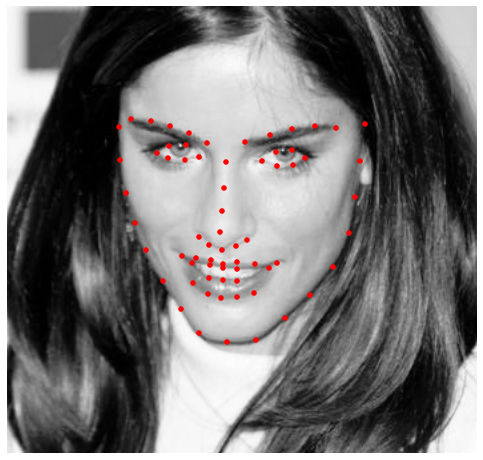

In [3]:
visualize_images(training_images)

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

Importing assets: [==========] 100% (224/224) - 00:00:00 remaining


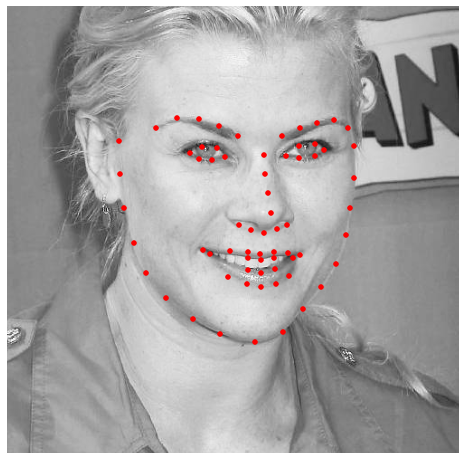

In [7]:
visualize_images(test_images)

## Build Active Appearance Models

In [8]:
features = fast_dsift
diagonal = 100
scales = (1, .5)
scale_shapes = False
scale_features = True
max_shape_components= 25
max_appearance_components = 200

#### AAM

In [9]:
aam_builder = AAMBuilder(
    features=features,
    diagonal=diagonal, 
    scales=scales, 
    scale_shapes=scale_shapes,
    scale_features=scale_features,
    max_shape_components=max_shape_components,
    max_appearance_components=max_appearance_components)

aam = aam_builder.build(
    training_images, 
    group='ibug_face_66', 
    verbose=True)

- Building models
  - Level 0: Done
  - Level 1: Done


## Fit Active Appearance Models

#### AAM Fitters at different sampling rates

In [41]:
aam_fitter_1 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=WibergInverseCompositional, 
    n_shape=[5, 15], 
    n_appearance=[50, 100],
    sampling=[1])

In [42]:
aam_fitter_2 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=WibergInverseCompositional, 
    n_shape=[5, 15], 
    n_appearance=[50, 100],
    sampling=[2])

In [43]:
aam_fitter_4 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=WibergInverseCompositional, 
    n_shape=[5, 15], 
    n_appearance=[50, 100],
    sampling=[4])

In [44]:
aam_fitter_8 = LucasKanadeAAMFitter(
    aam, 
    lk_algorithm_cls=WibergInverseCompositional, 
    n_shape=[5, 15], 
    n_appearance=[50, 100],
    sampling=[8])

#### Fitting loop

In [45]:
fitters = [aam_fitter_1,
           aam_fitter_2,
           aam_fitter_4,
           aam_fitter_8]
           
fitters_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    np.random.seed(2)
    s = fitters[0].noisy_shape_from_shape(gt_s, noise_std=0.02)

    for fitter in fitters:
        
        fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=20) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print 'Image: ', j
        print fr

Image:  0
Initial error: 0.0780
Final error: 0.0155
Image:  0
Initial error: 0.0780
Final error: 0.0155
Image:  0
Initial error: 0.0780
Final error: 0.0160
Image:  0
Initial error: 0.0780
Final error: 0.0183
Image:  1
Initial error: 0.0744
Final error: 0.0180
Image:  1
Initial error: 0.0744
Final error: 0.0178
Image:  1
Initial error: 0.0744
Final error: 0.0175
Image:  1
Initial error: 0.0744
Final error: 0.0192
Image:  2
Initial error: 0.0830
Final error: 0.0482
Image:  2
Initial error: 0.0830
Final error: 0.0481
Image:  2
Initial error: 0.0830
Final error: 0.0509
Image:  2
Initial error: 0.0830
Final error: 0.0525
Image:  3
Initial error: 0.0980
Final error: 0.0255
Image:  3
Initial error: 0.0980
Final error: 0.0260
Image:  3
Initial error: 0.0980
Final error: 0.0278
Image:  3
Initial error: 0.0980
Final error: 0.0299
Image:  4
Initial error: 0.1583
Final error: 0.0279
Image:  4
Initial error: 0.1583
Final error: 0.0299
Image:  4
Initial error: 0.1583
Final error: 0.0294
Image:  4
In

##  Results

In [54]:
initial_errors = [fr.initial_error() for fr in fitters_results[::4]]

final_errors_1 = [fr.final_error() for fr in fitters_results[::4]]
final_errors_2 = [fr.final_error() for fr in fitters_results[1::4]]
final_errors_4 = [fr.final_error() for fr in fitters_results[2::4]]
final_errors_8 = [fr.final_error() for fr in fitters_results[3::4]]

errors = [initial_errors, final_errors_1, final_errors_2, final_errors_4, final_errors_8]

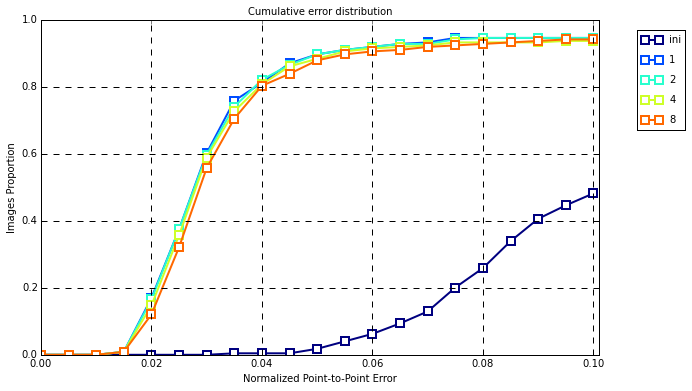

In [55]:
plot_ced(errors, legend_entries=['ini', '1', '2', '4', '8'])

In [56]:
print 'mean_1:', np.mean(errors_1), 'std_1:', np.std(errors_1)
print 'mean_2:', np.mean(errors_2), 'std_2:', np.std(errors_2)
print 'mean_4:', np.mean(errors_4), 'std_4:', np.std(errors_4)
print 'mean_8:', np.mean(errors_8), 'std_8:', np.std(errors_8)

mean_1: 0.0371373252947 std_1: 0.0373908630423
mean_2: 0.0372009127165 std_2: 0.0375684009487
mean_4: 0.0385368073246 std_4: 0.0392818458615
mean_8: 0.0394771962577 std_8: 0.0395808403681


In [70]:
from scipy import stats  

# ANOVA test
f_val, p_val1 = stats.f_oneway(final_errors_1, final_errors_2, 
                              final_errors_4, final_errors_8)  

# Kruskal-Wallis H-test
h_stat, p_val2 = stats.kruskal(final_errors_1, final_errors_2, 
                             final_errors_4, final_errors_8)

print "One-way ANOVA,", "\tp-value:", p_val1, "f-value:", f_val
print "Kruskal-Wallis," "\tp-value:", p_val2, "h-stat:", h_stat  

One-way ANOVA, 	p-value: 0.901881220314 f-value: 0.19198782615
Kruskal-Wallis,	p-value: 0.541230076431 h-stat: 2.15317573779


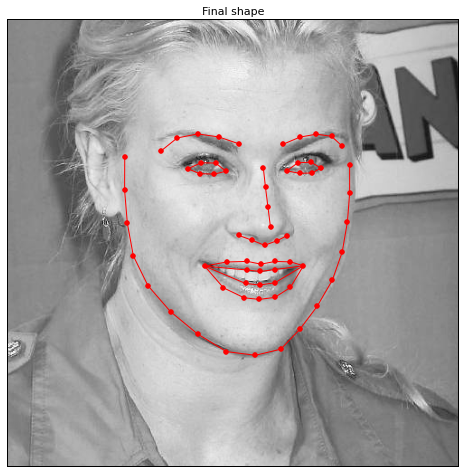

In [49]:
visualize_fitting_result(fitters_results[::4])

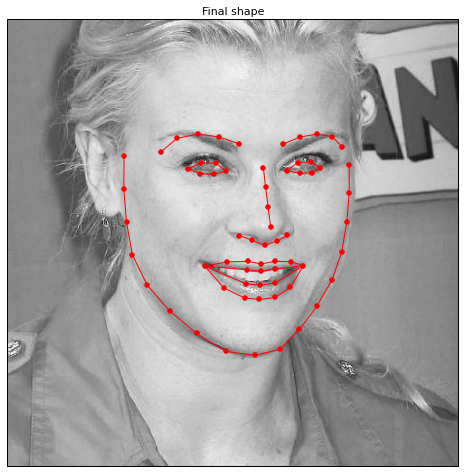

In [50]:
visualize_fitting_result(fitters_results[1::4])

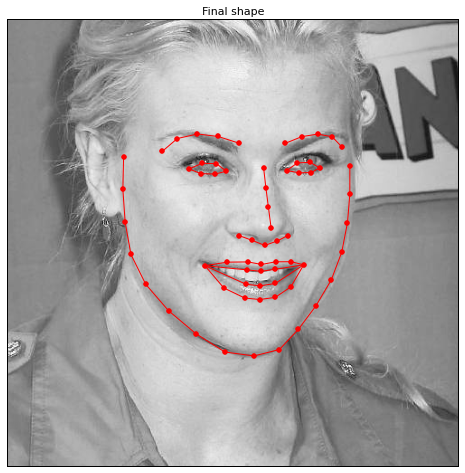

In [51]:
visualize_fitting_result(fitters_results[2::4])

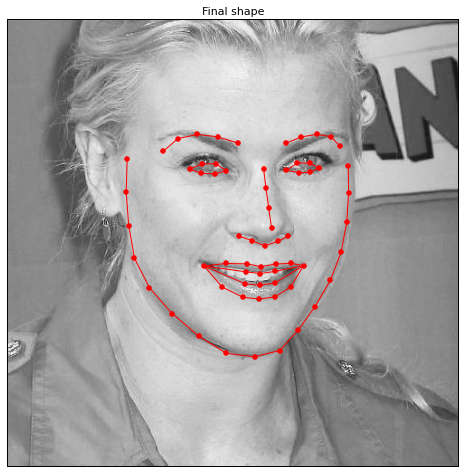

In [52]:
visualize_fitting_result(fitters_results[3::4])

In [53]:
%timeit fr = aam_fitter_1.fit(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = aam_fitter_2.fit(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = aam_fitter_4.fit(i, s, gt_shape=gt_s, max_iters=20) 
%timeit fr = aam_fitter_8.fit(i, s, gt_shape=gt_s, max_iters=20) 

1 loops, best of 3: 413 ms per loop
1 loops, best of 3: 331 ms per loop
1 loops, best of 3: 273 ms per loop
1 loops, best of 3: 241 ms per loop
